<a href="https://colab.research.google.com/github/BhawnaMehbubani/August-LeetCode-Challenge/blob/master/Deep_Learning_Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import time
import copy
from itertools import product

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import datasets, transforms, models

from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score
from tqdm import tqdm

In [ ]:
# ----------------------------
# Reproducibility
# ----------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [ ]:
# ----------------------------
# Config / Paths
# ----------------------------
OUT_DIR = "cifar_experiments"
os.makedirs(OUT_DIR, exist_ok=True)
BEST_MODEL_PATH = os.path.join(OUT_DIR, "best_model.pth")

In [ ]:
# ----------------------------
# Data transforms and loaders
# ----------------------------
# For AlexNet we will resize to 224. For custom CNN we can keep 32 or resize as desired.
transform_train_alex = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(224, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test_alex = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# For custom CNN we use 32x32 baseline transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2470, 0.2435, 0.2616))
])

# Download CIFAR-10
dataset_train_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform_train)
dataset_test = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

# We'll create a validation split from the train set (e.g., 45k train + 5k val)
val_size = 5000
train_size = len(dataset_train_full) - val_size
dataset_train, dataset_val = random_split(dataset_train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

# Simpler approach: reload CIFAR10 with alex transforms for alexnet
dataset_train_full_alex = datasets.CIFAR10(root="./data", train=True, download=False, transform=transform_train_alex)
dataset_test_alex = datasets.CIFAR10(root="./data", train=False, download=False, transform=transform_test_alex)
dataset_train_alex, dataset_val_alex = random_split(dataset_train_full_alex, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))


100%|██████████| 170M/170M [00:03<00:00, 44.0MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


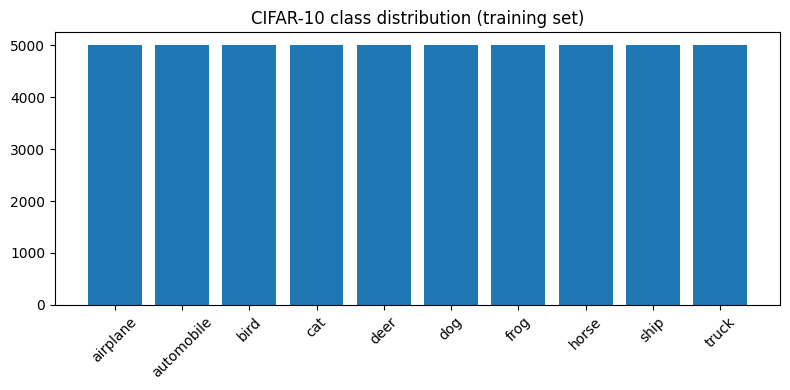

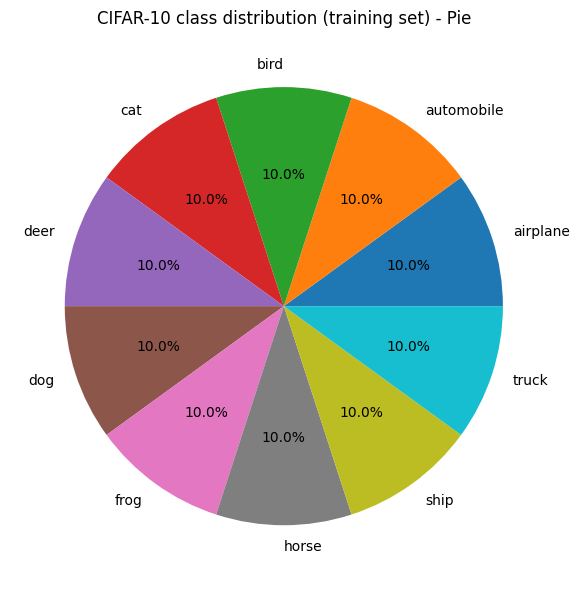

In [ ]:
# Class names
classes = dataset_train_full.classes
num_classes = len(classes)
print("Classes:", classes)

# Visualize class distribution (on the full train dataset)
def plot_class_distribution():
    labels = [label for _, label in dataset_train_full]
    counts = np.bincount(labels, minlength=num_classes)
    # Histogram
    plt.figure(figsize=(8,4))
    plt.bar(range(num_classes), counts, tick_label=classes)
    plt.title("CIFAR-10 class distribution (training set)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "class_histogram.png"))
    plt.show()

    # Pie chart
    plt.figure(figsize=(6,6))
    plt.pie(counts, labels=classes, autopct='%1.1f%%')
    plt.title("CIFAR-10 class distribution (training set) - Pie")
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "class_pie.png"))
    plt.show()

plot_class_distribution()

In [ ]:
# ----------------------------
# AlexNet implementation (adapted)
# ----------------------------
class AlexNetCIFAR(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetCIFAR, self).__init__()
        # Use the torchvision AlexNet but adjusted final classifier for num_classes,
        # or implement a smaller variant:
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),  # output ~ (64, 54, 54) for 224 input
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # classifier
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),  # assumes input 224-> after convs ~6x6
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * imgs.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
# ----------------------------
# Function to train AlexNet and plot accuracy curves
# ----------------------------
def run_alexnet_experiment(epochs=20, batch_size=128, lr=1e-3, optimizer_name='Adam'):
    print("Preparing data loaders for AlexNet...")
    train_loader = DataLoader(dataset_train_alex, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(dataset_val_alex, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(dataset_test_alex, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    model = AlexNetCIFAR(num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()

    if optimizer_name.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

    best_val_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[], 'test_acc':[]}

    for epoch in range(1, epochs+1):
        start = time.time()
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)
        # Evaluate on test set each epoch (this is optional but the user asked to plot test accuracy)
        _, test_acc, _, _ = evaluate(model, test_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['test_acc'].append(test_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'epoch': epoch}, os.path.join(OUT_DIR, "alexnet_best.pth"))

        elapsed = time.time() - start
        print(f"Epoch {epoch}/{epochs} - train_acc: {train_acc:.4f}, val_acc: {val_acc:.4f}, test_acc: {test_acc:.4f}, time: {elapsed:.1f}s")

    # restore best
    model.load_state_dict(best_model_wts)

    # Plot epoch vs train/val/test accuracy
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), history['train_acc'], label='train_acc')
    plt.plot(range(1, epochs+1), history['val_acc'], label='val_acc')
    plt.plot(range(1, epochs+1), history['test_acc'], label='test_acc')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("AlexNet - Accuracy curves")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(OUT_DIR, "alexnet_accuracy_curves.png"))
    plt.show()

    return model, history


In [ ]:
# ----------------------------
# Build a configurable CNN dynamically
# ----------------------------
class SimpleCNN(nn.Module):
    def __init__(self, in_channels=3, num_classes=10, conv_layers_cfg=[(32,3), (64,3), (128,3)], use_batchnorm=True, pool_every=2):
        """
        conv_layers_cfg: list of tuples (num_filters, kernel_size)
        pool_every: apply MaxPool after every 'pool_every' conv layers
        """
        super(SimpleCNN, self).__init__()
        layers = []
        channels = in_channels
        conv_count = 0
        for (out_channels, k) in conv_layers_cfg:
            padding = k // 2
            layers.append(nn.Conv2d(channels, out_channels, kernel_size=k, padding=padding))
            if use_batchnorm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU(inplace=True))
            conv_count += 1
            if conv_count % pool_every == 0:
                layers.append(nn.MaxPool2d(2))
            channels = out_channels

        self.feature_extractor = nn.Sequential(*layers)

        # compute flattened feature size for classifier (assumes input 32x32)
        # we can forward a dummy tensor to compute final shape dynamically
        with torch.no_grad():
            dummy = torch.zeros(1, in_channels, 32, 32)
            feat = self.feature_extractor(dummy)
            flattened = feat.shape[1] * feat.shape[2] * feat.shape[3]

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(flattened, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# ----------------------------
# Hyperparameter tuning routine (simple grid search)
# ----------------------------
def tune_and_train(grid, max_epochs=30, early_stop_patience=6, verbose=True):
    """
    grid: dict of lists for parameters:
      - conv_layers_options: list of lists e.g. [[(32,3),(64,3),(128,3)], ...]
      - batch_size_options: [64,128]
      - lr_options: [1e-3, 1e-4]
      - optimizer_options: ['Adam','RMSprop']
      - epochs_options: [20] (we'll still use max_epochs)
    We'll run combinations and pick best by validation accuracy.
    """
    best_val = 0.0
    best_result = {}
    # Pre-create test loader (32x32 transforms)
    test_loader = DataLoader(dataset_test, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)

    combos = list(product(grid['conv_layers_options'], grid['batch_size_options'],
                          grid['lr_options'], grid['optimizer_options'], grid['epochs_options']))
    print(f"{len(combos)} combinations to try.")

    for idx, (conv_cfg, batch_size, lr, opt_name, epochs) in enumerate(combos, 1):
        print(f"\n--- Running combo {idx}/{len(combos)} ---")
        print("conv_cfg:", conv_cfg, "batch:", batch_size, "lr:", lr, "opt:", opt_name, "epochs:", epochs)

        # Dataloaders
        train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
        val_loader = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

        model = SimpleCNN(conv_layers_cfg=conv_cfg, num_classes=num_classes).to(device)
        criterion = nn.CrossEntropyLoss()
        if opt_name.lower() == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        else:
            optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)

        best_local_val = 0.0
        best_local_wts = copy.deepcopy(model.state_dict())
        epochs_no_improve = 0

        history = {'train_acc':[], 'val_acc':[]}

        for epoch in range(1, epochs+1):
            train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
            val_loss, val_acc, _, _ = evaluate(model, val_loader, criterion, device)

            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)

            print(f"[{idx}] Epoch {epoch}/{epochs} - train_acc {train_acc:.4f}, val_acc {val_acc:.4f}")

            # early stopping
            if val_acc > best_local_val + 1e-6:
                best_local_val = val_acc
                best_local_wts = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= early_stop_patience:
                print("Early stopping")
                break

        # Evaluate the best local model on validation and test
        model.load_state_dict(best_local_wts)
        _, val_acc_final, val_preds, val_labels = evaluate(model, val_loader, criterion, device)
        _, test_acc_final, test_preds, test_labels = evaluate(model, test_loader, criterion, device)

        print(f"Combo {idx} finished. val_acc={val_acc_final:.4f}, test_acc={test_acc_final:.4f}")

        # Save if best
        if val_acc_final > best_val:
            best_val = val_acc_final
            best_result = {
                'conv_cfg': conv_cfg,
                'batch_size': batch_size,
                'lr': lr,
                'optimizer': opt_name,
                'epochs_ran': epoch,
                'val_acc': val_acc_final,
                'test_acc': test_acc_final,
                'model_state_dict': copy.deepcopy(model.state_dict()),
                'history': history
            }
            torch.save({
                'model_state_dict': best_result['model_state_dict'],
                'config': {
                    'conv_cfg': conv_cfg,
                    'batch_size': batch_size,
                    'lr': lr,
                    'optimizer': opt_name
                }
            }, BEST_MODEL_PATH)
            print("New best saved.")

    return best_result

In [ ]:
# ----------------------------
# Metrics and final evaluation
# ----------------------------
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    precision_macro = precision_recall_fscore_support(y_true, y_pred, average='macro')[0]
    recall_macro = precision_recall_fscore_support(y_true, y_pred, average='macro')[1]
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_weighted = precision_recall_fscore_support(y_true, y_pred, average='weighted')[0]
    recall_weighted = precision_recall_fscore_support(y_true, y_pred, average='weighted')[1]
    f1_weighted = f1_score(y_true, y_pred, average='weighted')

    return {
        'accuracy': acc,
        'precision_macro': precision_macro,
        'recall_macro': recall_macro,
        'f1_macro': f1_macro,
        'precision_weighted': precision_weighted,
        'recall_weighted': recall_weighted,
        'f1_weighted': f1_weighted
    }

=== Running AlexNet baseline ===
Preparing data loaders for AlexNet...
Epoch 1/12 - train_acc: 0.3076, val_acc: 0.4300, test_acc: 0.4423, time: 113.2s
Epoch 2/12 - train_acc: 0.4692, val_acc: 0.5146, test_acc: 0.5155, time: 112.5s
Epoch 3/12 - train_acc: 0.5249, val_acc: 0.5554, test_acc: 0.5553, time: 121.3s
Epoch 4/12 - train_acc: 0.5596, val_acc: 0.5968, test_acc: 0.6054, time: 116.8s
Epoch 5/12 - train_acc: 0.5838, val_acc: 0.6082, test_acc: 0.6008, time: 114.5s
Epoch 6/12 - train_acc: 0.6052, val_acc: 0.6330, test_acc: 0.6363, time: 111.7s
Epoch 7/12 - train_acc: 0.6220, val_acc: 0.6414, test_acc: 0.6433, time: 117.9s
Epoch 8/12 - train_acc: 0.6372, val_acc: 0.6676, test_acc: 0.6707, time: 111.9s
Epoch 9/12 - train_acc: 0.6506, val_acc: 0.6770, test_acc: 0.6652, time: 111.4s
Epoch 10/12 - train_acc: 0.6603, val_acc: 0.6938, test_acc: 0.6890, time: 118.9s
Epoch 11/12 - train_acc: 0.6678, val_acc: 0.6890, test_acc: 0.6711, time: 111.6s
Epoch 12/12 - train_acc: 0.6738, val_acc: 0.687

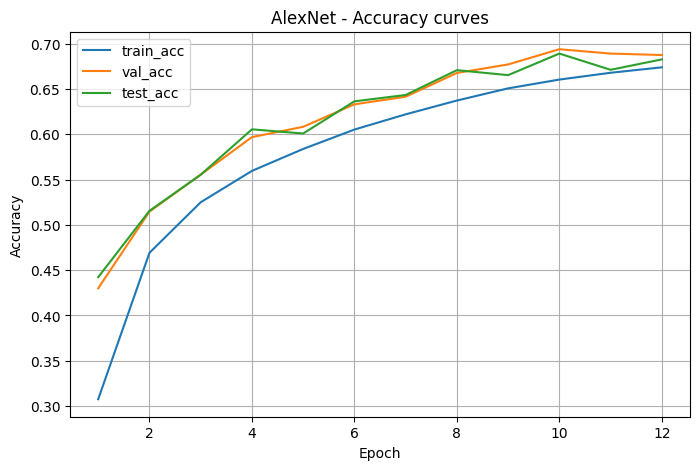

AlexNet test metrics: {'accuracy': 0.689, 'precision_macro': 0.689803756588451, 'recall_macro': 0.6890000000000001, 'f1_macro': 0.6868098931029312, 'precision_weighted': 0.689803756588451, 'recall_weighted': 0.689, 'f1_weighted': 0.6868098931029312}
=== Starting hyperparameter tuning ===
16 combinations to try.

--- Running combo 1/16 ---
conv_cfg: [(32, 3), (64, 3), (128, 3)] batch: 128 lr: 0.001 opt: Adam epochs: 20


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


[1] Epoch 1/20 - train_acc 0.3021, val_acc 0.3714
[1] Epoch 2/20 - train_acc 0.3758, val_acc 0.5262
[1] Epoch 3/20 - train_acc 0.4109, val_acc 0.5156
[1] Epoch 4/20 - train_acc 0.4296, val_acc 0.5578
[1] Epoch 5/20 - train_acc 0.4461, val_acc 0.5824
[1] Epoch 6/20 - train_acc 0.4608, val_acc 0.6042
[1] Epoch 7/20 - train_acc 0.4733, val_acc 0.6130
[1] Epoch 8/20 - train_acc 0.4792, val_acc 0.6368
[1] Epoch 9/20 - train_acc 0.4813, val_acc 0.6196
[1] Epoch 10/20 - train_acc 0.4923, val_acc 0.5876
[1] Epoch 11/20 - train_acc 0.5002, val_acc 0.6482
[1] Epoch 12/20 - train_acc 0.5078, val_acc 0.6556
[1] Epoch 13/20 - train_acc 0.5106, val_acc 0.6096
[1] Epoch 14/20 - train_acc 0.5185, val_acc 0.6628
[1] Epoch 15/20 - train_acc 0.5257, val_acc 0.6546
[1] Epoch 16/20 - train_acc 0.5305, val_acc 0.6726
[1] Epoch 17/20 - train_acc 0.5381, val_acc 0.6714
[1] Epoch 18/20 - train_acc 0.5395, val_acc 0.6706
[1] Epoch 19/20 - train_acc 0.5484, val_acc 0.7014
[1] Epoch 20/20 - train_acc 0.5553, val_

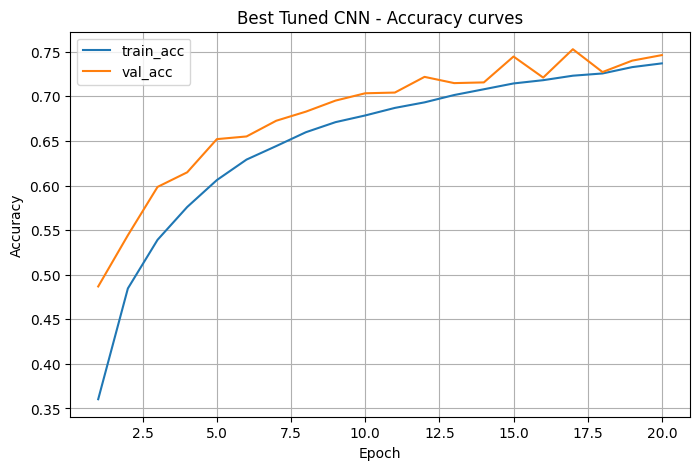

All done. Artifacts (models, plots) saved in: cifar_experiments


In [ ]:
# ----------------------------
# Putting it all together
# ----------------------------
if __name__ == "__main__":
    # 1) Run AlexNet baseline
    alex_epochs = 12
    alex_batch = 128
    alex_lr = 1e-3
    alex_optimizer = 'Adam'
    print("=== Running AlexNet baseline ===")
    alex_model, alex_hist = run_alexnet_experiment(epochs=alex_epochs, batch_size=alex_batch, lr=alex_lr, optimizer_name=alex_optimizer)

    # Evaluate AlexNet best weights on test and report
    test_loader = DataLoader(dataset_test_alex, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
    criterion = nn.CrossEntropyLoss()
    _, _, alex_test_preds, alex_test_labels = evaluate(alex_model, test_loader, criterion, device)
    alex_metrics = compute_metrics(alex_test_labels, alex_test_preds)
    print("AlexNet test metrics:", alex_metrics)

    # 2) Hyperparameter tuning for custom CNN
    # Define a small grid (expand as you have compute)
    grid = {
        'conv_layers_options': [
            [(32,3), (64,3), (128,3)],       # 3 conv layers
            [(32,3), (64,3), (128,3), (128,3)],  # 4 conv layers
        ],
        'batch_size_options': [128, 256],
        'lr_options': [1e-3, 1e-4],
        'optimizer_options': ['Adam', 'RMSprop'],
        'epochs_options': [20],  # maximum epochs for each combo
    }

    print("=== Starting hyperparameter tuning ===")
    best = tune_and_train(grid, max_epochs=25, early_stop_patience=5)

    print("Best config found:", best.get('conv_cfg'), best.get('batch_size'), best.get('lr'), best.get('optimizer'))
    print("Best val acc:", best.get('val_acc'), "test acc:", best.get('test_acc'))

    # Load best model and compute test metrics in detail
    if best:
        model_best = SimpleCNN(conv_layers_cfg=best['conv_cfg'], num_classes=num_classes).to(device)
        model_best.load_state_dict(best['model_state_dict'])
        test_loader = DataLoader(dataset_test, batch_size=256, shuffle=False, num_workers=4, pin_memory=True)
        _, _, test_preds, test_labels = evaluate(model_best, test_loader, nn.CrossEntropyLoss(), device)
        final_metrics = compute_metrics(test_labels, test_preds)
        print("Final tuned model test metrics:")
        for k,v in final_metrics.items():
            print(f"  {k}: {v:.4f}")

        # Plot epoch vs training and validation accuracy for best run (if history available)
        hist = best.get('history')
        if hist:
            epochs_ran = len(hist['train_acc'])
            plt.figure(figsize=(8,5))
            plt.plot(range(1, epochs_ran+1), hist['train_acc'], label='train_acc')
            plt.plot(range(1, epochs_ran+1), hist['val_acc'], label='val_acc')
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Best Tuned CNN - Accuracy curves")
            plt.legend()
            plt.grid(True)
            plt.savefig(os.path.join(OUT_DIR, "tunedcnn_accuracy_curves.png"))
            plt.show()

    print("All done. Artifacts (models, plots) saved in:", OUT_DIR)